# ISYE 6740:  HW3 Q1 Solution

*Spring 2020*

In [1]:
from matplotlib import pyplot as plt;
import numpy as np;
import networkx as nx;
np.set_printoptions(precision=2);
import os;
os.makedirs("out", exist_ok=True)

### Problem Statement

> The objective of this question is to reproduce the ISOMAP algorithm results that we have seen discussed in lecture as an excercise. The file `isomap.dat` contains 698 images, corresponding to different poses of the same face. Each image is given as a 64 × 64
luminosity map, hence represented as a vector in $\mathbb{R}^{4096}$. This vector is stored as a row in the
file. This is one of the datasets used in the original paper for ISOMAP, [J.B. Tenenbaum,
V. de Silva, and J.C. Langford, Science 290 (2000) 2319-2323.]()

### Importing Data

In [2]:
# datafile stored in same folder
import scipy.io;
data = scipy.io.loadmat('isomap.mat')

# note: images array will be (698x4096)
images = data["images"].T;
(num_img,img_dim) = np.shape(images);
print("num_img:", num_img);
print("img_dim:", img_dim);

num_img: 698
img_dim: 4096


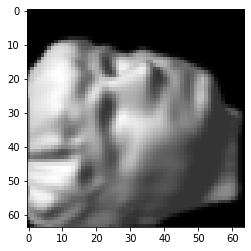

In [3]:
# plot the first image
plt.imshow(np.reshape(images[0], (64,64)), cmap="gray");

## Part A

From the homework PDF:

>  Choose the Euclidean distance between images (i.e., in this case a distance in $\mathbb{R}^{4096}$). Construct a similarity graph with vertices corresponding to the images, and tune the threshold $\epsilon$ so that each node has at least 100 neighbors. Visualize the similarity graph (e.g., plot the adjacency matrix, or visualize the graph and illustrate a few images corresponds to nodes at  different parts of the graph; you can be a bit creative here).

Since we'll be comparing multiple distance functions, let's put all our graph-generating code in a function;

In [4]:
# euclidean distance
def l2_distance(x,y):
    return np.sqrt(np.sum((x-y)**2))

# manhattan distance
def l1_distance(x,y):
    return np.sum(np.abs(x-y));

def make_sim_graph(images, dist_func):
    num_img = len(images);
    
    # Generate Matrix for Similarity Graph
    G = np.zeros([num_img,num_img])
    for i in range(num_img):
        for j in range(i,num_img):
            G[i,j] = G[j,i] = dist_func(images[i], images[j])


    # tune threshold so each node has at least 100 neighbors
    edge_threshold = 0;

    for i in range(num_img):
        # find a threshold that guarantees this node has 100 neighbors
        # (assuming it had >= 100 neighbors to begin with)
        weights = np.sort(G[i,:]);
        if len(weights) > 100:
            weights = weights[:100];

        min_threshold = weights[-1];
        edge_threshold = max(min_threshold, edge_threshold);

    for i in range(num_img):
        for j in range(i, num_img):
            if G[i,j] > edge_threshold:
                G[i,j] = G[j,i] = 99999.0;
    
    return G;

Now let's actually call our function using the imported data with euclidean distance for edge weights:

In [5]:
G_l2 = make_sim_graph(images, l2_distance);
#np.savetxt('out/W_l2.csv', G_l2)

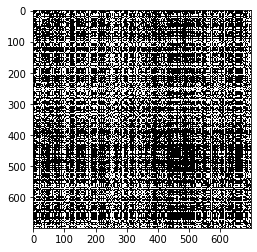

In [6]:
# plot adjacency matrix by intensity
plt.figure()
plt.imshow(G_l2,cmap="gray")
plt.savefig('out/hw3_q2_adjacency.png', dpi=600)

## Part B

> Implement the ISOMAP algorithm and apply it to this graph to obtain a
d = 2-dimensional embedding. Present a plot of this embedding. Find three points
that are “close” to each other in the embedding space, and show what they look like.
Do you see any visual similarity among them?

The following function uses the edge weights computed above to build a graph whose edge weights are shortest-path distances between points:

In [7]:
def Matrix_D(W):
    # Generate Graph and Obtain Matrix D, \\
    # from weight matrix W defining the weight on the edge between each pair of nodes.
    # Note that you can assign sufficiently large weights to non-existing edges.
 
    n = np.shape(W)[0]
    Graph = nx.DiGraph()
    for i in range(n):
        for j in range(n):
            Graph.add_weighted_edges_from([(i,j,min(W[i,j], W[j,i]))])
 
    res = dict(nx.all_pairs_dijkstra_path_length(Graph))
    D = np.zeros([n,n])
    for i in range(n):
        for j in range(n):
            D[i,j] = res[i][j]
    
    return D

Finally, we implement ISOMAP:

In [8]:
def isomap(G):
    num_img = len(G);
    
    D = Matrix_D(G)
    print('D:', D)

    D = (D + D.T)/2
    print(np.max(D-D.T))
    
    # Compute Matrix C
    ones = np.ones([num_img,1])
    H = np.eye(num_img) - 1/num_img*ones.dot(ones.T)
    C = -H.dot(D**2).dot(H)/(2*num_img)
    
    eig_val, eig_vec = np.linalg.eig(C)
    
    index = np.argsort(-eig_val) # Sort eigenvalue from large to small
    print(eig_val[index[0:2]])
    Z = eig_vec[:,index[0:2]].dot(np.diag(1/np.sqrt(eig_val[index[0:2]])))
    print(np.shape(Z))
    
    return Z;

Let's run our ISOMAP function:

In [9]:
Z_l2 = isomap(G_l2);

D: [[ 0.   18.83  6.74 ... 21.51 28.51 18.04]
 [18.83  0.   19.55 ... 15.07 21.63 20.97]
 [ 6.74 19.55  0.   ... 25.29 26.95 18.68]
 ...
 [21.51 15.07 25.29 ...  0.   28.34 17.2 ]
 [28.51 21.63 26.95 ... 28.34  0.   20.31]
 [18.04 20.97 18.68 ... 17.2  20.31  0.  ]]
0.0
[99.14 80.76]
(698, 2)


Last, we save a plot of the embedding, and compare three nearby points.  They do indeed look similar!  All the faces are pointing down.

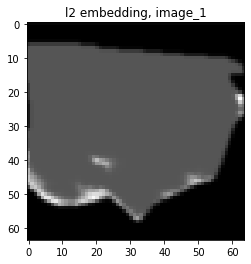

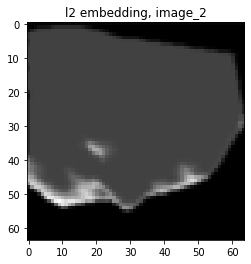

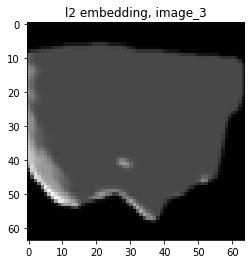

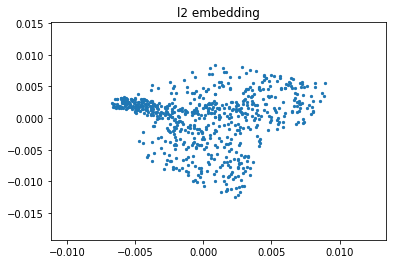

In [10]:
index = np.argsort(Z_l2[:,0])[0:3]
img_1 = np.reshape(images[index[0]], [64, -1])
img_2 = np.reshape(images[index[1]], [64, -1])
img_3 = np.reshape(images[index[2]], [64, -1])
for i in range(3):
    plt.figure()
    plt.title('l2 embedding, image_'+str(i+1))
    plt.imshow(eval('img_'+str(i+1)), cmap=plt.get_cmap('gray'))
    plt.savefig('out/l2_image_'+str(i+1)+'.png', dpi = 600)
 
# Plot Embedding
plt.figure()
plt.scatter(Z_l2[:,0], Z_l2[:,1], s = 5)
plt.title("l2 embedding")
plt.savefig('out/embedding_l2.png', dpi=600)

## Part C

We do the whole process again, this time with $\ell_1$ distance!

In [11]:
G_l1 = make_sim_graph(images, l1_distance);
Z_l1 = isomap(G_l1);

D: [[   0.    965.31  257.37 ... 1180.24 1333.19  801.12]
 [ 965.31    0.    998.81 ...  591.33 1219.31 1257.45]
 [ 257.37  998.81    0.   ... 1292.46 1314.56  854.54]
 ...
 [1180.24  591.33 1292.46 ...    0.   1235.03  736.96]
 [1333.19 1219.31 1314.56 ... 1235.03    0.    906.33]
 [ 801.12 1257.45  854.54 ...  736.96  906.33    0.  ]]
0.0
[227514.38 189671.61]
(698, 2)


We also generate the same plots:

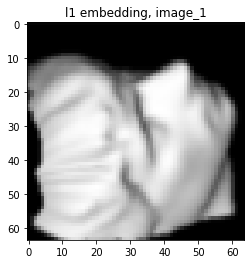

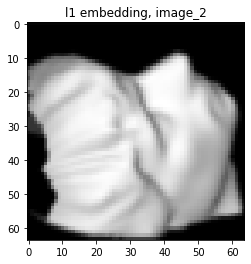

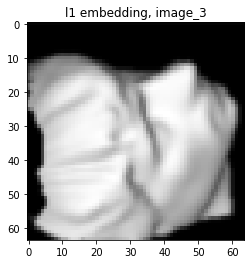

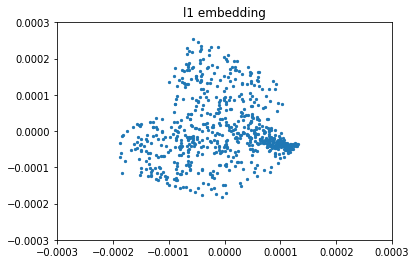

In [16]:
index = np.argsort(Z_l1[:,0])[0:3]
img_1 = np.reshape(images[index[0]], [64, -1])
img_2 = np.reshape(images[index[1]], [64, -1])
img_3 = np.reshape(images[index[2]], [64, -1])
for i in range(3):
    plt.figure()
    plt.title('l1 embedding, image_'+str(i+1))
    plt.imshow(eval('img_'+str(i+1)), cmap=plt.get_cmap('gray'))
    plt.savefig('out/l1_image_'+str(i+1)+'.png', dpi = 600)
 
# Plot Embedding
plt.figure()
plt.scatter(Z_l1[:,0], Z_l1[:,1], s = 5)
plt.xlim(-0.0003, 0.0003);
plt.ylim(-0.0003, 0.0003);
plt.title("l1 embedding")
plt.savefig('out/embedding_l1.png', dpi=600)